In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries


In [4]:
import torch
from torchvision.transforms import transforms
import cv2
from torch.utils.data import DataLoader
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import linear
from torch.nn.modules.activation import ReLU
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix

# Unzip data


In [ ]:
# unzip all dataset
!unzip '/content/drive/MyDrive/noise_classification_phase16_red_green_blue_and_positive_blury_augmented_with_replaced_data_including_RGB_negative_and_RGB_positive_data_51561_training_3985_validation.zip'

In [ ]:
## unzip all_train data
!unzip '/content/drive/MyDrive/training_data_all.zip' 

In [ ]:
## unzip all_test data
!unzip '/content/drive/MyDrive/testing_data_all.zip'

In [6]:
test_n = os.listdir('/content/testing_data/negative')
len(test_n)

1508

In [ ]:
test_p = os.listdir('/content/testing_data/positive')
len(test_p)

977

In [ ]:
train_n = os.listdir('/content/training_data/negative')
len(train_n)

20742

In [ ]:
train_p = os.listdir('/content/training_data/positive')
len(train_p)

11983

# Prepare data

## Remove wrong dimensions

In [ ]:
## remove wrong dimensions from the negative trainset
path = '/content/training_data/negative/'
for i in train_n:
  a = cv2.imread(path+i)
  if a.shape == (256, 320, 3):
    os.remove(path +i)
print(len(train_n))  

21461


In [ ]:
## remove wrong dimensions from the positive trainset
path = '/content/training_data/positive/'
for i in train_p:
  a = cv2.imread(path+i)
  if a.shape == (256, 320, 3):
    os.remove(path +i)
print(len(train_p))  

12400


## Create train and validation data


In [ ]:
#Transforms

transformer=transforms.Compose([
    transforms.ToTensor()  #0-255 to 0-1, numpy to tensors
])

In [ ]:
# load the data with labels

# path of training data
train_path = '/content/training_data'
test_path = '/content/testing_data'

# load the train and test data with labels
train_data = ImageFolder(train_path ,transform=transformer)
test_data = ImageFolder(test_path, transform=transformer)

In [ ]:
# set a batch size for train_set and test_set

train = DataLoader(train_data, batch_size=16 , shuffle=True)
test = DataLoader(test_data , batch_size=16, shuffle=True)

# Model architecture

In [7]:
### Model architecture

model = nn.Sequential(
    
    # convolution layer 1                     # input shape(16,3,320,256)
    nn.Conv2d(in_channels =3 ,out_channels= 16, kernel_size = 3, stride=1, padding=1),
    nn.BatchNorm2d(num_features=16),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size = 2), #(16,16,160,128)


    # convolution layer 2
    nn.Conv2d(in_channels = 16 ,out_channels= 32, kernel_size = 3, stride=1, padding=1),  # output shape after conv2 (16,32,160,128)
    nn.BatchNorm2d(num_features=32),
    nn.LeakyReLU(),  # output shape after relu1  (16,32,160,128)
    nn.MaxPool2d(kernel_size = 2),   # output shape after max pooling  (16,32,80,64)


    # convolution layer 3
    nn.Conv2d(in_channels = 32 ,out_channels= 64, kernel_size = 3, stride=1, padding=1),   # output shape after conv2  (16,64,80,64)
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(),   # output shape after relu1  (16,64,80,64)
    nn.MaxPool2d(kernel_size = 2),   # output shape after max pooling  (16,64,40,32)

    # convolutional layer 4
    nn.Conv2d(in_channels = 64 ,out_channels= 64, kernel_size = 3, stride=1, padding=1),   # output shape after conv2  (16,64,40,32)
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(),   # output shape after relu1  (16,64,40,32)
    nn.MaxPool2d(kernel_size = 2),   # output shape after max pooling  (16,64,20,16)    

    # flatten layer
    nn.Flatten(),
    
    # dropout
    nn.Dropout(p=0.2),

    # fully connected layer
    nn.Linear(in_features=64*20*16,out_features=250),
    nn.LeakyReLU(), 
    nn.Dropout(p=0.2),
    nn.Linear(in_features=250,out_features=50),
    nn.LeakyReLU(), 
    nn.Dropout(p=0.2),
    nn.Linear(in_features=50,out_features=1),
    #nn.Sigmoid()
)

# Define loss function and optimizer


In [8]:
# optimizer and loss function

lossfn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

# Enable GPU and model summary

In [9]:
# enable GPU

device = 'cuda'
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
from torchsummary import summary

print(summary(model, (3,320,256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 320, 256]             448
       BatchNorm2d-2         [-1, 16, 320, 256]              32
         LeakyReLU-3         [-1, 16, 320, 256]               0
         MaxPool2d-4         [-1, 16, 160, 128]               0
            Conv2d-5         [-1, 32, 160, 128]           4,640
       BatchNorm2d-6         [-1, 32, 160, 128]              64
         LeakyReLU-7         [-1, 32, 160, 128]               0
         MaxPool2d-8           [-1, 32, 80, 64]               0
            Conv2d-9           [-1, 64, 80, 64]          18,496
      BatchNorm2d-10           [-1, 64, 80, 64]             128
        LeakyReLU-11           [-1, 64, 80, 64]               0
        MaxPool2d-12           [-1, 64, 40, 32]               0
           Conv2d-13           [-1, 64, 40, 32]          36,928
      BatchNorm2d-14           [-1, 64,

# Model training and validation

In [ ]:
# Save checkpoint if a new best is achieved
# Save checkpoint if test loss is minimum

# Save checkpoint if a new best is achieved
def best_save_checkpoint(state, is_best, filename):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("")

# Save checkpoint if test loss is minimum
def min_save_checkpoint(state, is_min, filename):
    if is_min:
        print ("")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("")
      

In [ ]:
# final code with graph
# save best accuracy 
# save minimum loss
# save train test accuracy and loss
# code for training and evalution
# code for plot between training and testing accuracy
# code for plot between training and testing loss

def train_model(model,lossfn ,optimizer,epochs=100):
  min_loss = 15.00
  best_acc = 0.0
  inter = 5
  training_acc = []
  training_loss = []
  testing_acc =[]
  testing_loss = []
  ## empty dict for appending acc and loss
  dic ={'training_acc': [], 'training_loss': [],'testing_acc':
                    [],'testing_loss':[]}
  
  for epoch in range(1,epochs+1):
    train_loss = 0.0
    train_acc = 0.0
    
    model.train()

    for img ,label in train:
      img = img.cuda()
      label = label.cuda()

      pred = model(img)
      label = label.unsqueeze(1)
      label = label.float()

      loss = lossfn(pred, label)
           
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
         
      train_loss += loss.item()
      train_acc += ((pred > 0.0) == label).sum().item()

    training_acc.append(train_acc/len(train_data))
    training_loss.append(train_loss/len(train))

    # append per epoch train acc and loss
    dic['training_acc'].append(train_acc/len(train_data))
    dic['training_loss'].append(train_loss/len(train))
    # dict to dataframe
    df = pd.DataFrame.from_dict(dic, orient='index') 
    df = df.transpose()
    # convert df to csv and save csv
    df.to_csv('/content/drive/MyDrive/save_acc_and_loss_second.csv',index=False)

    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
      for img, label in test:
        img = img.cuda()
        label = label.cuda()

        pred = model(img)
        label = label.unsqueeze(1)
        label = label.float()
        loss = lossfn(pred,label)

        test_loss += loss.item()

        test_acc += ((pred > 0.0) == label).sum().item()

    testing_acc.append(test_acc/len(test_data))
    testing_loss.append(test_loss/len(test))

    # append per epoch test acc and loss
    dic['testing_acc'].append(test_acc/len(test_data))
    dic['testing_loss'].append(test_loss/len(test))
    # dict to dataframe
    df = pd.DataFrame.from_dict(dic, orient='index') 
    df = df.transpose()
    # convert df to csv and save csv
    df.to_csv('/content/drive/MyDrive/save_acc_and_loss_second.csv',index=False)

    ### save best test accuracy
    # get a accuracy of each epoch
    valid_acc_1 = test_acc/len(test_data)    
    # get boolian type base on current acc grater than the previous one
    # for make if condition true and false
    is_best = bool(valid_acc_1 > best_acc)
    # save previous acc in variable named best accuracy 
    best_acc = (max(valid_acc_1 , best_acc))

    #### save minimum test loss
    # get a loss of each epoch
    test_loss_1 = test_loss/len(test)
    # get boolian type base on current loss less than the previous one
    # for make if condition true and false
    is_min = bool(test_loss_1 < min_loss)
    # save previous acc in variable named best accuracy 
    min_loss = test_loss_1

    # print matrix
    print('epoch {} , training acc {:.4f} , testing acc {:.4f}, training loss {:.4f} , testing loss {:.4f}'.format(
        epoch , 100*train_acc/len(train_data) , 100*test_acc/len(test_data), train_loss/len(train), test_loss/len(test)
    ))
    
    #### call save_checkpoint function 
    # save best test accuracy
    best_save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_accuracy': best_acc
    }, is_best,'/content/drive/MyDrive/'+'model_epoch_'+str(epoch)+'_best_test_accuracy_'+str(best_acc)+'_second'+'.pth' ) 
    
    #### call min_save_checkpoint
    # save minimum test loss 
    min_save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'min_test_loss': min_loss
    }, is_min,'/content/drive/MyDrive/'+'model_epoch_'+str(epoch)+'_min_test_loss_'+str(min_loss)+'_second'+'.pth' ) 

    #### save checkpoints at a interval
    if epoch % inter == 0:
      torch.save({
        'epoch': epoch,
        'state_dict': model.state_dict()
      },'/content/drive/MyDrive/'+'model_at_interval_epoch_'+str(epoch)+'_second'+'.pth' ) 
 
  # plot training and testing accuracy
  plt.title('training and testing accuracy VS epochs')
  plt.plot(range(epochs), training_acc , label = 'training accuracy')
  plt.plot(range(epochs), testing_acc , label = 'testing accuracy')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('training VS testing accuracy')
  plt.savefig('/content/drive/MyDrive/training and testing accuracy graph second.jpg')
  plt.show()

  # plot training and testing loss
  plt.title('training and testing loss VS epochs')
  plt.plot(range(epochs), training_loss , label = 'training loss')
  plt.plot(range(epochs), testing_loss , label = 'testing loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('training VS testing loss')
  plt.savefig('/content/drive/MyDrive/training and testing loss graph second.jpg')
  plt.show()

epoch 1 , training acc 91.7341 , testing acc 97.1026, training loss 0.2437 , testing loss 0.0987


epoch 2 , training acc 95.1841 , testing acc 96.4588, training loss 0.1570 , testing loss 0.1123


epoch 3 , training acc 95.8197 , testing acc 97.9879, training loss 0.1387 , testing loss 0.1020


epoch 4 , training acc 96.6417 , testing acc 98.9537, training loss 0.1156 , testing loss 0.0707


epoch 5 , training acc 97.0053 , testing acc 99.0744, training loss 0.1053 , testing loss 0.0561


epoch 6 , training acc 97.0420 , testing acc 98.9537, training loss 0.0990 , testing loss 0.0421


epoch 7 , training acc 97.4118 , testing acc 99.0342, training loss 0.0920 , testing loss 0.0431


epoch 8 , training acc 97.4454 , testing acc 99.0342, training loss 0.0900 , testing loss 0.0420


epoch 9 , training acc 97.6898 , testing acc 98.5915, training loss 0.0822 , testing loss 0.0515


epoch 10 , training acc 97.6715 , testing acc 98.9135, training loss 0.0824 , testing loss 0.0348


epoch 11 

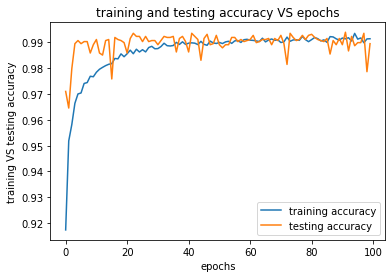

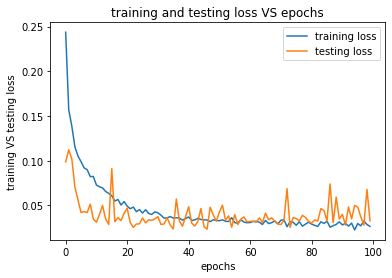

In [ ]:
# call the train model function
train_model(model,lossfn = nn.BCEWithLogitsLoss() , optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4))

# Plot accuracy and loss graph on both training and validation

In [ ]:
## plot and save graph of saved acc and loss

# read csv file
data = pd.read_csv('/content/drive/MyDrive/save_acc_and_loss.csv')

# plot training and testing accuracy
plt.title('training and testing accuracy VS epochs')
plt.plot(range(1,4),data['training_acc'] , label = 'training accuracy')
plt.plot(range(1,4), data['testing_acc'] , label = 'testing accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('training VS testing accuracy')
plt.savefig('/content/drive/MyDrive/training and testing accuracy graph.jpg')
plt.show()

# plot training and testing loss
plt.title('training and testing loss VS epochs')
plt.plot(range(1,4), data['training_loss'] , label = 'training loss')
plt.plot(range(1,4), data['testing_loss'] , label = 'testing loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('training VS testing loss')
plt.savefig('/content/drive/MyDrive/training and testing loss graph.jpg')
plt.show()
plt.close()

# Resuming training

## Load last epoch for retraining

In [10]:
# function for loading model's weights

def load_model(filepath):
  checkpoints = torch.load(filepath)
  model.load_state_dict(checkpoints['state_dict'])
  print("=> loaded checkpoint '{}')".format(filepath))

In [11]:
# call the load_model
load_model('/content/drive/MyDrive/model_at_interval_epoch_50_.pth')

=> loaded checkpoint '/content/drive/MyDrive/model_epoch_65_min_test_loss_0.030830490661826797_second.pth')


## Initialize model, loss function and optimizer

In [ ]:
### for resuming training first intialize model, loss function and optimizer
model = model()
# optimizer and loss fuction
lossfn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

## Retrain 

In [ ]:
##### run this code for resuming training
# final code with save graph
# save best accuracy 
# save minimum loss
# code for training and evalution
# code for plot between training and testing accuracy
# code for plot between training and testing loss

def train_model(model,lossfn ,optimizer,epochs=100):
  min_loss = 15.00
  best_acc = 0.0
  inter = 5
  training_acc = []
  training_loss = []
  testing_acc =[]
  testing_loss = []
  ## empty dict for appending acc and loss
  dic ={'training_acc': [], 'training_loss': [],'testing_acc':
                    [],'testing_loss':[]}
  
  for epoch in range(51,epochs+1):
    train_loss = 0.0
    train_acc = 0.0
    
    model.train()

    for img ,label in train:
      img = img.cuda()
      label = label.cuda()

      pred = model(img)
      label = label.unsqueeze(1)
      label = label.float()

      loss = lossfn(pred, label)
           
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
         
      train_loss += loss.item()
      train_acc += ((pred > 0.0) == label).sum().item()

    training_acc.append(train_acc/len(train_data))
    training_loss.append(train_loss/len(train))

    # append per epoch train acc and loss
    dic['training_acc'].append(train_acc/len(train_data))
    dic['training_loss'].append(train_loss/len(train))
    # dict to dataframe
    df = pd.DataFrame.from_dict(dic, orient='index') 
    df = df.transpose()
    # convert df to csv and save csv
    df.to_csv('/content/drive/MyDrive/save_acc_and_loss_re.csv',index=False)

    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
      for img, label in test:
        img = img.cuda()
        label = label.cuda()

        pred = model(img)
        label = label.unsqueeze(1)
        label = label.float()
        loss = lossfn(pred,label)

        test_loss += loss.item()

        test_acc += ((pred > 0.0) == label).sum().item()

    testing_acc.append(test_acc/len(test_data))
    testing_loss.append(test_loss/len(test))

    # append per epoch test acc and loss
    dic['testing_acc'].append(test_acc/len(test_data))
    dic['testing_loss'].append(test_loss/len(test))
    # dict to dataframe
    df = pd.DataFrame.from_dict(dic, orient='index') 
    df = df.transpose()
    # convert df to csv and save csv
    df.to_csv('/content/drive/MyDrive/save_acc_and_loss_re.csv',index=False)

    ### save best test accuracy
    # get a accuracy of each epoch
    valid_acc_1 = test_acc/len(test_data)    
    # get boolian type base on current acc grater than the previous one
    # for make if condition true and false
    is_best = bool(valid_acc_1 > best_acc)
    # save previous acc in variable named best accuracy 
    best_acc = (max(valid_acc_1 , best_acc))

    #### save minimum test loss
    # get a loss of each epoch
    test_loss_1 = test_loss/len(test)
    # get boolian type base on current loss less than the previous one
    # for make if condition true and false
    is_min = bool(test_loss_1 < min_loss)
    # save previous acc in variable named best accuracy 
    min_loss = test_loss_1

    # print matrix
    print('epoch {} , training acc {:.4f} , testing acc {:.4f}, training loss {:.4f} , testing loss {:.4f}'.format(
        epoch , train_acc/len(train_data) , test_acc/len(test_data), train_loss/len(train), test_loss/len(test)
    ))
    
    #### call save_checkpoint function 
    # save best test accuracy
    best_save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_accuracy': best_acc
    }, is_best,'/content/drive/MyDrive/'+'model_epoch_'+str(epoch)+'_best_test_accuracy_'+str(best_acc)+'_re'+'.pth' ) 
    
    #### call min_save_checkpoint
    # save minimum test loss 
    min_save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'min_test_loss': min_loss
    }, is_min,'/content/drive/MyDrive/'+'model_epoch_'+str(epoch)+'_min_test_loss_'+str(min_loss)+'_re'+'.pth' ) 

    #### save checkpoints at a interval
    if epoch % inter == 0:
      torch.save({
        'epoch': epoch,
        'state_dict': model.state_dict()
      },'/content/drive/MyDrive/'+'model_at_interval_epoch_'+str(epoch)+'_re'+'.pth' ) 
 
  # plot training and testing accuracy
  plt.title('training and testing accuracy VS epochs')
  plt.plot(range(51,101), training_acc , label = 'training accuracy')
  plt.plot(range(51,101), testing_acc , label = 'testing accuracy')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('training VS testing accuracy')
  plt.savefig('/content/drive/MyDrive/training and testing accuracy graph_re.jpg')
  plt.show()

  # plot training and testing loss
  plt.title('training and testing loss VS epochs')
  plt.plot(range(51,101), training_loss , label = 'training loss')
  plt.plot(range(51,101), testing_loss , label = 'testing loss')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('training VS testing loss')
  plt.savefig('/content/drive/MyDrive/training and testing loss graph_re.jpg')
  plt.show()

In [ ]:
# call the train model function for resuming training

train_model(model,lossfn = nn.BCEWithLogitsLoss() , optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4))

# Prediction on validation data

## Load the best epoch model 

In [1]:
# prediction on this model
# function for loading best epoch model's weights

def load_model(filepath):
  checkpoints = torch.load(filepath)
  model.load_state_dict(checkpoints['state_dict'])
  print("=> loaded checkpoint '{}' (best epoch acco to accu is {})".format(filepath, checkpoints['epoch']))

In [ ]:
# call the load_model
load_model('/content/drive/MyDrive/model_epoch_65_min_test_loss_0.030830490661826797_second.pth')

## Prediction

In [ ]:
## import excel for prediction 

df = pd.read_excel('/content/noise_classification_phase16_red_green_blue_and_positive_blury_augmented_with_replaced_data_including_RGB_negative_and_RGB_positive_data_51561_training_3985_validation/Positive_and_Negative_Image_List_For_Validation_Data.xlsx')
df.drop(df.index[0], inplace=True)
df

,Positive Images,Unnamed: 1,Unnamed: 2,Negative Images,Unnamed: 4
1,1 (24)_861629221943940_p15.jpg,3 (238)_648974563096188_p47.jpg,1 (81)_363803451864247_p87.jpg,1 001-1_885494224561108_p16.jpg,1 (83)_847040809088190_p2.jpg
2,1th Oct_AES-440_2021-11-29_17.56.01.285330_p33...,3 (93)_972673831581048_p21.jpg,1 (81)_363803451864247_p88.jpg,1 (15)_617963421152291_p67.jpg,1 (83)_847040809088190_p8.jpg
3,1th Oct_BCFK Vendors_2021-11-29_17.56.35.46108...,20211016_110432_260006110987504_p365.jpg,3 (5)_166099970888047_p9.jpg,1 (74)_910391362696360_p7.jpg,2 (34)_992408847791318_p7.jpg
4,1th Oct_BCFK Vendors_2021-11-29_17.56.35.46108...,20211016_112057_754238000694693_p155.jpg,3 (5)_166099970888047_p21.jpg,1 (74)_910391362696360_p17.jpg,3 (8)_204772202747717_p4.jpg
5,1th Oct_BCFK Vendors_2021-11-29_17.56.35.46108...,20211016_101308_712799138319312_p526.jpg,3 (60)_372164614337844_p31.jpg,1 (74)_910391362696360_p27.jpg,3 (9)_244922191255372_p48.jpg
...,...,...,...,...,...
1504,NaN,NaN,NaN,IMG_20211105_171411_p13.jpg,NaN
1505,NaN,NaN,NaN,IMG_20211207_173740_750783629070973_p102.jpg,NaN
1506,NaN,NaN,NaN,P_20211008_155733_p140.jpg,NaN
1507,NaN,NaN,NaN,20211130_141216_p72.jpg,NaN


In [ ]:
# first load best epoch
# prediction on negative image 
source = '/content/noise_classification_phase16_red_green_blue_and_positive_blury_augmented_with_replaced_data_including_RGB_negative_and_RGB_positive_data_51561_training_3985_validation/val/Negative_Images/'
c = 0
dic = {'images': [], 'true_label': [], 'prediction': []}
for i in df['Negative Images']:
  dic['images'].append(i)
  dic['true_label'].append(c)
  image = cv2.imread(source+i)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = transforms.Compose([transforms.ToTensor()])
  image = transform(image)
  image = image.cuda()
  image = image.unsqueeze(0)
  pred = model(image)
  if (pred > 0.0):
    pred = 1
  else:
    pred = 0
  dic['prediction'].append(pred)
  dataf = pd.DataFrame.from_dict(dic, orient='index') 
  dataf = dataf.transpose()
  dataf.to_csv('/content/drive/MyDrive/with_negative_prediction_file_true_second1_65.csv',index=False)

In [ ]:
# prediction on positive image 
# first load best epoch
source = '/content/noise_classification_phase16_red_green_blue_and_positive_blury_augmented_with_replaced_data_including_RGB_negative_and_RGB_positive_data_51561_training_3985_validation/val/Positive_Images/'
c = 1
dic = {'images': [], 'true_label': [], 'prediction': []}
for image in df['Positive Images']:
  dic['images'].append(image)
  dic['true_label'].append(c)
  image = cv2.imread(source+image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = transforms.Compose([transforms.ToTensor()])
  image = transform(image)
  image = image.cuda()
  image = image.unsqueeze(0)
  #print(image.shape)
  pred = model(image)
  if (pred > 0.0):
    pred = 1
  else:
    pred = 0
  dic['prediction'].append(pred)
  dataf = pd.DataFrame.from_dict(dic, orient='index') 
  dataf = dataf.transpose()
  dataf.to_csv('/content/drive/MyDrive/with_posi_prediction_file_true_second1_65.csv',index=False)

In [ ]:
# read pred csv
df_p = pd.read_csv('/content/drive/MyDrive/with_posi_prediction_file_true_second1_65.csv')
df_n = pd.read_csv('/content/drive/MyDrive/with_negative_prediction_file_true_second1_65.csv')

In [ ]:
## append dataframe
all_pred = df_p.append(df_n)

## all_pred convert to csv
all_pred.to_csv('/content/drive/MyDrive/all_positive_and_negative_prediction_true_second1_65.csv', index=False)

In [26]:
# evalution matrix of model
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix

In [16]:
con = pd.read_csv('/content/drive/MyDrive/all_positive_and_negative_prediction_true_second1_65.csv')
con

,images,true_label,prediction,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1 (24)_861629221943940_p15.jpg,1,1,NaN,NaN,NaN,NaN,NaN
1,1th Oct_AES-440_2021-11-29_17.56.01.285330_p33...,1,1,NaN,NaN,NaN,NaN,NaN
2,1th Oct_BCFK Vendors_2021-11-29_17.56.35.46108...,1,1,NaN,NaN,NaN,NaN,NaN
3,1th Oct_BCFK Vendors_2021-11-29_17.56.35.46108...,1,1,NaN,NaN,NaN,NaN,NaN
4,1th Oct_BCFK Vendors_2021-11-29_17.56.35.46108...,1,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2480,IMG_20211105_171411_p13.jpg,0,0,NaN,NaN,NaN,NaN,NaN
2481,IMG_20211207_173740_750783629070973_p102.jpg,0,1,perfect image,NaN,NaN,NaN,NaN
2482,P_20211008_155733_p140.jpg,0,1,blue noise,NaN,NaN,NaN,NaN
2483,20211130_141216_p72.jpg,0,0,NaN,NaN,NaN,NaN,NaN


## Evalution matrix of validation dataset


In [ ]:
## evulation of epoch 65 model
# final best epoch on base architecture model 
# prediction on validation set

y_true =[]
y_pred = []
for true , pred in zip(con['true_label'],con['prediction']):
  y_true.append(true)
  y_pred.append(pred)
  
precision = precision_score(y_true,y_pred)
print('precison of model: ', 100* precision)

recall = recall_score(y_true,y_pred)
print('Recall of model: ',100*recall)

f1_sc = f1_score(y_true,y_pred)
print('F1_score is: ', 100*f1_sc)

accu = accuracy_score(y_true,y_pred)
print('Accuracy is: ', 100*accu)

matrix = confusion_matrix(y_true,y_pred)
print('Confusion matrix is: \n', matrix)

precison of model:  89.1566265060241
Recall of model:  98.4646878198567
F1_score is:  93.57976653696498
Confusion matrix is: 
 [[1391  117]
 [  15  962]]


# Prediction on Unseen dataset

## Load the best epoch

In [ ]:
# prediction unseen data
# function for loading best epoch model's weights

def load_model(filepath):
  checkpoints = torch.load(filepath)
  model.load_state_dict(checkpoints['state_dict'])
  print("=> loaded checkpoint '{}' (best epoch acco to accu is {})".format(filepath, checkpoints['epoch']))

In [ ]:
# call the load_model
load_model('/content/drive/MyDrive/model_epoch_65_min_test_loss_0.030830490661826797_second.pth')

## Prediction

In [18]:
## import unseen excel
df_unseen = pd.read_excel('/content/noise_classification_phase16_red_green_blue_and_positive_blury_augmented_with_replaced_data_including_RGB_negative_and_RGB_positive_data_51561_training_3985_validation/Positive_and_Negative_Image_List_for_Unseen_Data.xlsx')
df_unseen.drop(df_unseen.index[0], inplace=True)
df_unseen


,Positive Images,Unnamed: 1,Unnamed: 2,Negative Images,Unnamed: 4
1,1 (34)_186227055932487_p86.jpg,1 (35)_728640730084424_p45.jpg,3 (60)_372164614337844_p30.jpg,1 (3)_919955611431935_p1.jpg,1 (1)_108362223860265_p0.jpg
2,1 (34)_186227055932487_p87.jpg,0001_350813770332710_p98.jpg,3 (60)_372164614337844_p61.jpg,1 (3)_919955611431935_p8.jpg,1 (1)_108362223860265_p1.jpg
3,1 (34)_186227055932487_p88.jpg,0001_350813770332710_p108.jpg,3 (123)_708942198158761_p61.jpg,1 (3)_919955611431935_p10.jpg,1 (3)_457872351935026_p1.jpg
4,1 (34)_186227055932487_p96.jpg,0001_350813770332710_p109.jpg,4 (78)_581991537295425_p60.jpg,1 (3)_919955611431935_p11.jpg,1 (3)_457872351935026_p2.jpg
5,3 (5)_166099970888047_p10.jpg,3 (6)_447119371474755_p10.jpg,4 (262)_892163732156369_p116.jpg,1 (3)_919955611431935_p22.jpg,1 (3)_457872351935026_p6.jpg
...,...,...,...,...,...
1994,NaN,NaN,NaN,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,NaN
1995,NaN,NaN,NaN,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,NaN
1996,NaN,NaN,NaN,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,NaN
1997,NaN,NaN,NaN,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,NaN


In [19]:
# prediction on unseendata
# prediction on negative image 
source = '/content/noise_classification_phase16_red_green_blue_and_positive_blury_augmented_with_replaced_data_including_RGB_negative_and_RGB_positive_data_51561_training_3985_validation/unseen_set/Negative_Images/'
c = 0
dic = {'images': [], 'true_label': [], 'prediction': []}
for i in df_unseen['Negative Images']:
  dic['images'].append(i)
  dic['true_label'].append(c)
  image = cv2.imread(source+i)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = transforms.Compose([transforms.ToTensor()])
  image = transform(image)
  image = image.cuda()
  image = image.unsqueeze(0)
  pred = model(image)
  if (pred > 0.0):
    pred = 1
  else:
    pred = 0
  dic['prediction'].append(pred)
  dataf = pd.DataFrame.from_dict(dic, orient='index') 
  dataf = dataf.transpose()
  dataf.to_csv('/content/drive/MyDrive/unseen_data_/with_negative_prediction_file_unseendata_epoch_65.csv',index=False)

In [ ]:
# prediction on positive image 
# prediction on unseendata
source = '/content/noise_classification_phase16_red_green_blue_and_positive_blury_augmented_with_replaced_data_including_RGB_negative_and_RGB_positive_data_51561_training_3985_validation/unseen_set/Positive_Images/'
c = 1
dic = {'images': [], 'true_label': [], 'prediction': []}
for image in df_unseen['Positive Images']:
  dic['images'].append(image)
  dic['true_label'].append(c)
  image = cv2.imread(source+image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = transforms.Compose([transforms.ToTensor()])
  image = transform(image)
  image = image.cuda()
  image = image.unsqueeze(0)
  #print(image.shape)
  pred = model(image)
  if (pred > 0.0):
    pred = 1
  else:
    pred = 0
  dic['prediction'].append(pred)
  dataf = pd.DataFrame.from_dict(dic, orient='index') 
  dataf = dataf.transpose()
  dataf.to_csv('/content/drive/MyDrive/unseen_data_/with_positive_prediction_file_unseendata_epoch_65.csv',index=False)

In [21]:
df_unseen_p = pd.read_csv('/content/drive/MyDrive/unseen_data_/with_positive_prediction_file_unseendata_epoch_65.csv')
df_unseen_n = pd.read_csv('/content/drive/MyDrive/unseen_data_/with_negative_prediction_file_unseendata_epoch_65.csv')

In [22]:
df_all_unseen_data = df_unseen_p.append(df_unseen_n)
df_all_unseen_data

,images,true_label,prediction
0,1 (34)_186227055932487_p86.jpg,1,1
1,1 (34)_186227055932487_p87.jpg,1,1
2,1 (34)_186227055932487_p88.jpg,1,1
3,1 (34)_186227055932487_p96.jpg,1,1
4,3 (5)_166099970888047_p10.jpg,1,1
...,...,...,...
1993,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,0,0
1994,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,0,0
1995,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,0,1
1996,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,0,0


In [23]:
df_all_unseen_data.to_csv('/content/drive/MyDrive/unseen_data_/all_unseen_data_predi.csv',index=False)

In [5]:
# import unseen data predi csv
unseen = pd.read_csv('/content/drive/MyDrive/unseen_data_/all_unseen_data_predi.csv')
unseen

,images,true_label,prediction
0,1 (34)_186227055932487_p86.jpg,1,1
1,1 (34)_186227055932487_p87.jpg,1,1
2,1 (34)_186227055932487_p88.jpg,1,1
3,1 (34)_186227055932487_p96.jpg,1,1
4,3 (5)_166099970888047_p10.jpg,1,1
...,...,...,...
2988,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,0,0
2989,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,0,0
2990,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,0,1
2991,WhatsApp Image 2022-02-11 at 4.17.16 PM (1)_62...,0,0


## Evalution matrix of unseen data

In [7]:
## evulation of epoch 65 model
# final best epoch on base architecture model 
# prediction on validation set

y_true =[]
y_pred = []
for true , pred in zip(unseen['true_label'],unseen['prediction']):
  y_true.append(true)
  y_pred.append(pred)
  
precision = precision_score(y_true,y_pred)
print('precison of model: ', 100* precision)

recall = recall_score(y_true,y_pred)
print('Recall of model: ',100*recall)

f1_sc = f1_score(y_true,y_pred)
print('F1_score is: ', 100*f1_sc)

accu = accuracy_score(y_true,y_pred)
print('Accuracy is: ', 100*accu)

matrix = confusion_matrix(y_true,y_pred)
print('Confusion matrix is: \n', matrix)



precison of model:  85.06944444444444
Recall of model:  98.49246231155779
F1_score is:  91.2901723334886
Accuracy is:  93.75208820581356
Confusion matrix is: 
 [[1826  172]
 [  15  980]]
